In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import random
import math
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
import datetime
import operator 
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
confirmed_cases = pd.read_csv('C:/Users/Surya/Desktop/Mini Project/COVID-19-master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

cols = confirmed_cases.keys()
confirmed = confirmed_cases.loc[:, cols[4]:cols[66]]
dates = confirmed.keys()
world_cases = []

for i in dates:
    confirmed_sum = confirmed[i].sum()
    world_cases.append(confirmed_sum)
  


days_since_1_22 = np.array([i for i in range(len(dates))])
#world_cases = np.array(world_cases).reshape(-1, 1)

days_in_future = 10
future_forecast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forecast[:-10]



In [3]:
mycases=pd.DataFrame({"dates":days_since_1_22,"cases":world_cases})
mycases=mycases.set_index("dates")
len(mycases)
rolmean=pd.DataFrame(mycases['cases']).rolling(window=3).mean()
rolstd=pd.DataFrame(mycases['cases']).rolling(window=3).std()
print(rolmean,rolstd)

               cases
dates               
0                NaN
1                NaN
2         716.666667
3        1009.666667
4        1497.666667
...              ...
58     246759.666667
59     276435.000000
60     308485.333333
61     344707.666667
62     384067.000000

[63 rows x 1 columns]               cases
dates              
0               NaN
1               NaN
2        200.485245
3        394.507710
4        591.077265
...             ...
58     28656.615874
59     31040.691552
60     32917.366698
61     38543.753454
62     42004.329884

[63 rows x 1 columns]


In [4]:
rolmean['cases'].fillna(555, inplace=True)
print(rolmean['cases'].isnull().sum())


0


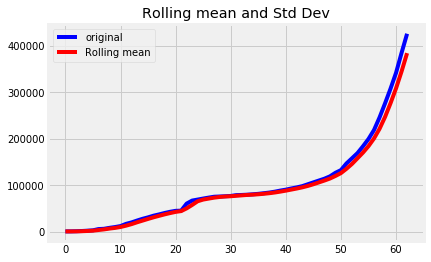

In [5]:
orig=plt.plot(mycases,color="blue",label="original")
mean=plt.plot(rolmean,color="red",label="Rolling mean")
plt.legend(loc="best")
plt.title("Rolling mean and Std Dev")
plt.show(block=False)

In [6]:
train_len = int(np.ceil(len(mycases) * 0.90))
print(len(mycases)-train_len)

6


In [7]:
train=rolmean[0:train_len] 
test=rolmean[train_len:]
print('Train data length :',len(train))
print('Test  data length :',len(test))

Train data length : 57
Test  data length : 6


In [8]:
x_train = train.drop('cases', axis=1)
x_test = test.drop('cases', axis=1)
y_train = train[['cases']]
y_test = test[['cases']]

In [9]:
model = SimpleExpSmoothing(train['cases'])

In [10]:
for i in np.arange(0.1,1,0.1):
    model_fit = model.fit(smoothing_level=i,optimized=False)
    y_hat_avg = test.copy()
    y_hat_avg['SES'] = model_fit.forecast(len(test['cases']))
    rmse = np.sqrt(mean_squared_error(test.cases, y_hat_avg.SES))
    rmse = round(rmse, 3)
    abs_error = np.abs(y_test['cases']-y_hat_avg.SES)
    actual = y_test['cases']
    mape = np.round(np.mean(abs_error/actual),4)
    print('smoothing_level : ',np.round(i,1),'RMSE : ' ,np.round(rmse,2) ,'MAPE : ',mape)

smoothing_level :  0.1 RMSE :  175521.84 MAPE :  0.5445
smoothing_level :  0.2 RMSE :  150725.88 MAPE :  0.4524
smoothing_level :  0.3 RMSE :  137840.03 MAPE :  0.4036
smoothing_level :  0.4 RMSE :  129734.91 MAPE :  0.3725
smoothing_level :  0.5 RMSE :  124196.36 MAPE :  0.351
smoothing_level :  0.6 RMSE :  120194.82 MAPE :  0.3353
smoothing_level :  0.7 RMSE :  117176.45 MAPE :  0.3234
smoothing_level :  0.8 RMSE :  114817.27 MAPE :  0.314
smoothing_level :  0.9 RMSE :  112917.59 MAPE :  0.3064


In [11]:
model_fit = model.fit(smoothing_level=0.9,optimized=True)
model_fit.params

{'smoothing_level': 0.9,
 'smoothing_slope': nan,
 'smoothing_seasonal': nan,
 'damping_slope': nan,
 'initial_level': 555.0,
 'initial_slope': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [12]:
y_hat_avg['SES'] = model_fit.forecast(len(test['cases']))

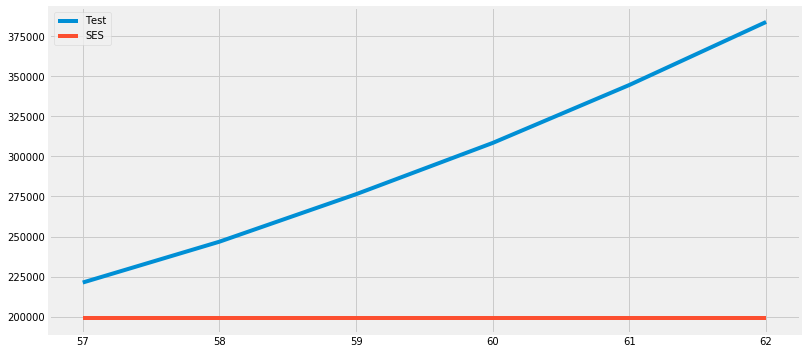

In [18]:
plt.figure(figsize=(12,6))
plt.plot(test['cases'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')

In [14]:
from statsmodels.tsa.api import Holt
fit1 = Holt(np.asarray(train['cases']),exponential=True).fit(smoothing_level=1,smoothing_slope=1,damping_slope=1, optimized=True)
fit1.params

{'smoothing_level': 1.0,
 'smoothing_slope': 1.0,
 'smoothing_seasonal': nan,
 'damping_slope': nan,
 'initial_level': 555.0,
 'initial_slope': 1.0,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [15]:
y_hat_avg['Holt'] = fit1.forecast(len(test))
print(y_hat_avg)

               cases            SES           Holt
dates                                             
57     221235.666667  198776.368898  218622.390872
58     246759.666667  198776.368898  238283.358684
59     276435.000000  198776.368898  259712.460372
60     308485.333333  198776.368898  283068.706288
61     344707.666667  198776.368898  308525.406769
62     384067.000000  198776.368898  336271.458158


In [16]:
#exponentialsmoothing
print('MAE:{}  || Actual Values: 8867 '.format(mean_absolute_error(y_hat_avg['Holt'], test['cases'])))
print('MSE:{}  || Actual Values: 283201302 '.format(mean_squared_error(y_hat_avg['Holt'], test['cases'])))

MAE:22867.758698369304  || Actual Values: 8867 
MSE:766315836.7732811  || Actual Values: 283201302 


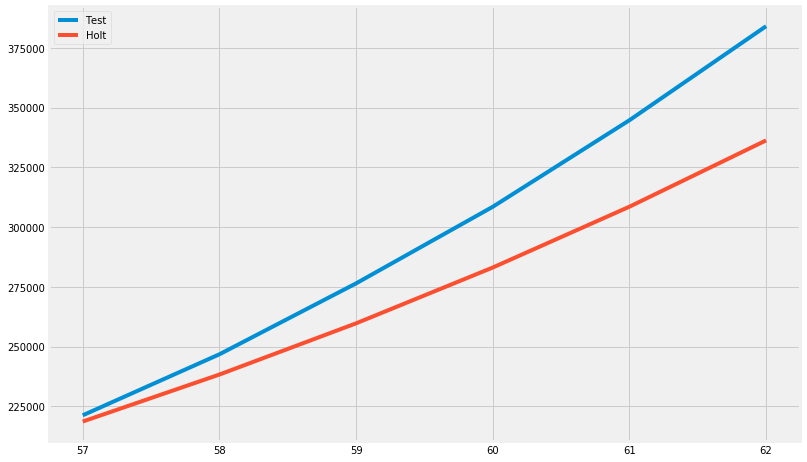

In [19]:
plt.figure(figsize=(12,8))
plt.plot(test['cases'], label='Test')
plt.plot(y_hat_avg['Holt'], label='Holt')
plt.legend(loc='best')
plt.show()